In [89]:
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem
from astropy.io import fits

from pathlib import Path


In [2]:
def calculating_stats(path, image_type):
    file_collection = ccdp.ImageFileCollection(path)
    files = file_collection.summary['imagetyp'] == image_type
    times = set(file_collection.summary['exptime'][files])
    if times:
        for exp_time in sorted(times):
            calibrated_files = file_collection.files_filtered(imagetyp=image_type, exptime=exp_time, include_path=True)
    else:
        raise(TypeError(f'Image type {image_type} does not exist'))
    pixel_values = np.empty(shape=(len(calibrated_files), 16389120))
    for index, file in enumerate(calibrated_files):
        with fits.open(file) as hdul:
            data = hdul[0].data.flatten()
            pixel_values = np.insert(pixel_values, index, data, axis = 0)
    pixel_values = pixel_values[:len(calibrated_files)]
    means = np.mean(pixel_values, axis = 0)
    std = np.std(pixel_values, axis = 0)
    standard_error_mean = sem(pixel_values, axis = 0)
    return pixel_values, means, std, standard_error_mean

In [3]:
dark_files_path = Path('..','2022_03_20', 'Dark')
dark_imagetype = 'Dark Frame'

dark_values, dark_mean, dark_std, dark_sem = calculating_stats(dark_files_path, dark_imagetype)

In [4]:
bias_path = Path('..','2022_03_20', 'Bias')
bias_imagetyp = 'Bias Frame'

bias_values, bias_mean, bias_std, bias_sem = calculating_stats(bias_path, bias_imagetyp)

In [5]:
flat_path = Path('..','2022_03_20', 'Flat', 'Luminance')
flat_imagetyp = 'Flat Frame'


flat_values, flat_mean, flat_std, flat_sem = calculating_stats(flat_path, flat_imagetyp)

In [40]:
import random
pixel_number = random.randint(1, 16389120)
plot_values_bias = bias_values[:, pixel_number]
plot_mean = bias_mean[pixel_number]
plot_median = np.median(bias_values[:, pixel_number])
master_bias = '../bias-reduced/combined_bias.fit'
master_bias_data = fits.getdata(master_bias)
master_data_point = master_bias_data.flatten()[pixel_number]

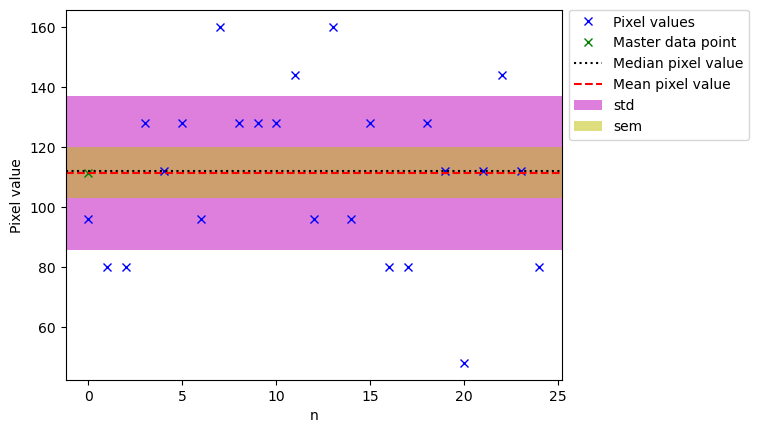

In [56]:
plt.plot(plot_values_bias, 'xb', label = 'Pixel values')
plt.plot(master_data_point, 'xg', label = 'Master data point')
plt.axhline(y = plot_median, color = 'black', linestyle = 'dotted', label = 'Median pixel value')
plt.axhline(y = plot_mean, color = 'r', linestyle = '--', label = 'Mean pixel value')
plt.axhspan(plot_mean + dark_std[pixel_number], plot_mean - dark_std[pixel_number], facecolor='m', alpha=0.5, label = 'std')
plt.axhspan(plot_mean + dark_sem[pixel_number], plot_mean - dark_sem[pixel_number], facecolor='y', alpha=0.5, label = 'sem')
plt.xlabel('n')
plt.ylabel('Pixel value')
plt.legend(bbox_to_anchor = (1, 1.02))
plt.savefig('Dark_example.png', bbox_inches="tight")

In [16]:
print(dark_std[5])
print(dark_sem[5])

80.78019559273176
26.926731864243916


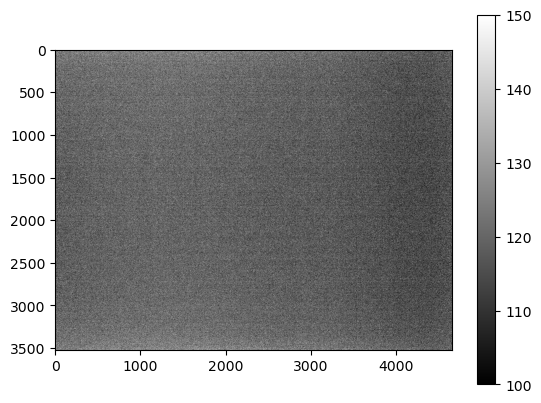

In [38]:
import os, random
file = random.choice(os.listdir('../2022_03_20/Bias'))

image_data = fits.getdata('../2022_03_20/Bias/' + file, ext=0)

plt.figure()
plt.imshow(image_data, cmap='gray', vmin = 100, vmax = 150)
plt.colorbar()
plt.savefig('Dark_noisy.png')

In [10]:
bias_mean

array([124.8 , 122.24, 122.24, ..., 118.4 , 134.4 , 122.24])

array([[144.,  80., 128., ..., 176., 240., 240.],
       [128., 160., 144., ..., 128., 192., 160.],
       [176., 160., 144., ..., 256.,  80., 128.],
       ...,
       [160., 128., 144., ...,  96., 144., 176.],
       [144., 208., 144., ..., 112., 112., 112.],
       [112., 144., 128., ..., 160., 112., 144.]])

(0.0, 400.0)

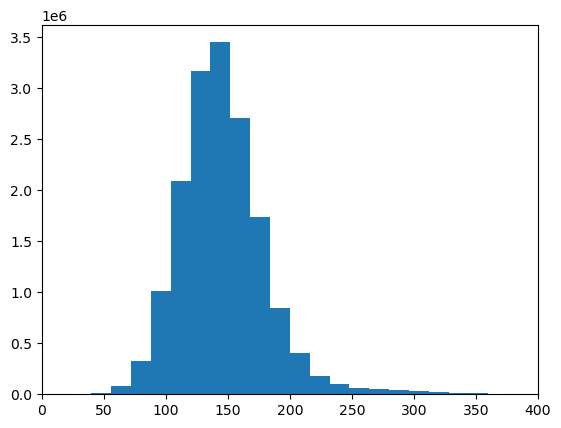

In [67]:
from astropy.visualization import hist
from astropy.stats import mad_std

hist(dark_values[0, :], bins='blocks');
plt.xlim(0,400)


In [68]:
np.mean(dark_values)

145.5448713292721

In [71]:
z = (dark_values - np.mean(dark_values)) / np.std(dark_values)
z

array([[-0.03201242, -1.35820349, -0.36356018, ...,  0.63108312,
         1.95727419,  1.95727419],
       [-0.36356018,  0.29953535, -0.03201242, ..., -0.36356018,
         0.96263089,  0.29953535],
       [ 0.63108312,  0.29953535, -0.03201242, ...,  2.28882196,
        -1.35820349, -0.36356018],
       ...,
       [ 0.29953535, -0.36356018, -0.03201242, ..., -1.02665572,
        -0.03201242,  0.63108312],
       [-0.03201242,  1.29417866, -0.03201242, ..., -0.69510795,
        -0.69510795, -0.69510795],
       [-0.69510795, -0.03201242, -0.36356018, ...,  0.29953535,
        -0.69510795, -0.03201242]])

(-4.0, 4.0)

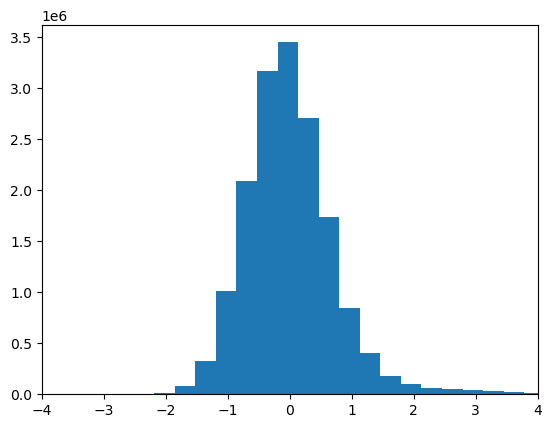

In [75]:
hist(z[0, :], bins='blocks');
plt.xlim(-4, 4)

In [76]:
average = np.average(dark_values, axis=0)
median = np.median(dark_values, axis=0)

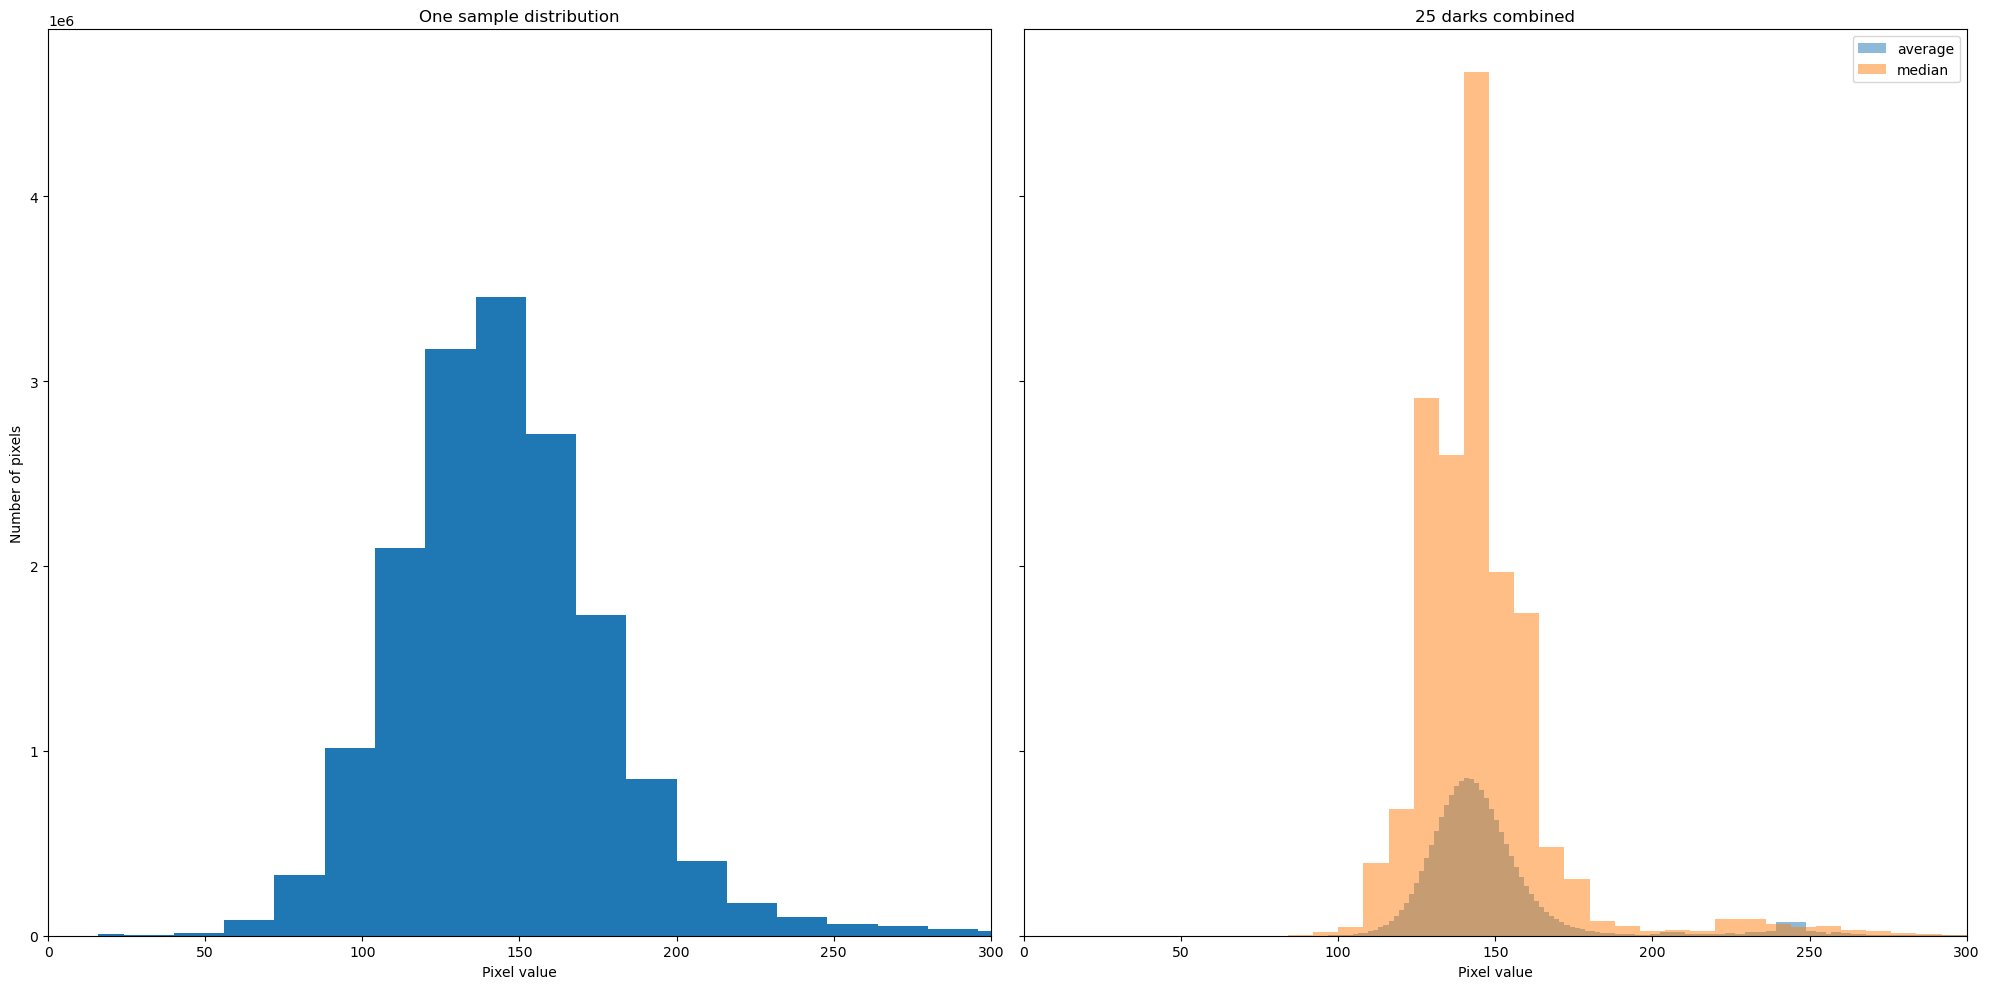

In [88]:
fig, ax = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(20, 10))

hist(dark_values[0, :], bins='blocks', ax=ax[0]);
ax[0].set_title('One sample distribution')
ax[0].set_xlabel('Pixel value')
ax[0].set_ylabel('Number of pixels')
ax[0].set_xlim(0, 300);

hist(average, bins='blocks', label='average', alpha=0.5, ax=ax[1]);
hist(median, bins='blocks', label='median', alpha=0.5, ax=ax[1]);
ax[1].set_title('25 darks combined')
ax[1].set_xlabel('Pixel value')
ax[1].legend()
ax[1].set_xlim(0, 300);
plt.savefig('Noise_histograms.png')

In [90]:
%%time
average_time = np.average(dark_values, axis=0)

CPU times: total: 266 ms
Wall time: 266 ms


In [91]:
%%time
median = np.median(dark_values, axis=0)

CPU times: total: 2.59 s
Wall time: 2.62 s


[1.0015105725811035, 20181.12, 20163.84, 20140.8, 20122.24, 20107.52, 20092.16, 20077.44, 20065.92, 20057.6, 20058.24, 20048.0, 20041.6, 20030.08, 20019.84, 20005.76, 19988.48, 19970.56, 19948.8, 19925.12, 19900.8, 19886.72, 19865.6, 19840.0, 19810.56, 19774.08]


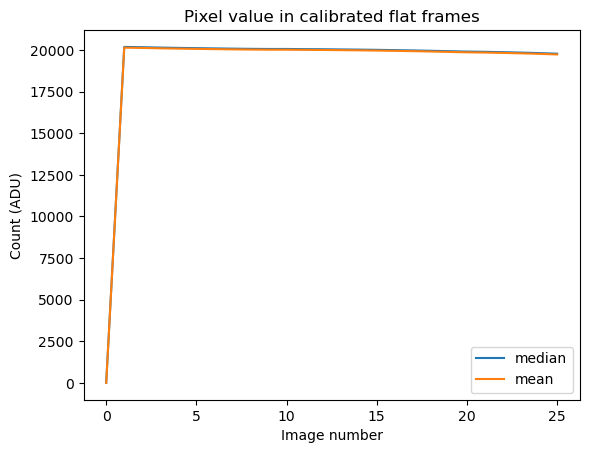

In [92]:
calibrated_flat_path = Path('..', 'reduced-flats')

flat_imagetyp = 'Flat Frame'

ifc = ccdp.ImageFileCollection(calibrated_flat_path)

median_count = [np.median(data) for data in ifc.data(imagetyp=flat_imagetyp)]
mean_count = [np.mean(data) for data in ifc.data(imagetyp=flat_imagetyp)]
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()
print(median_count)